In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import scipy
import scipy.integrate as integrate
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

In [3]:
def PlotMesh(vtx,elt,refine):

    x = vtx[:, 0]
    y = vtx[:, 1]

    plt.figure(figsize=(8, 6))
    plt.triplot(x, y, elt, 'k-') 
    plt.plot(x, y, 'ro', markersize = 10)
    
    for i, triangle in enumerate(elt):
        centroid_x = sum(x[triangle]) / 3
        centroid_y = sum(y[triangle]) / 3
        plt.text(centroid_x, centroid_y, str(i), fontsize=12, ha='center', va='center')
    plt.xlabel(r' Abscisse $x$')
    plt.ylabel(r'Ordonnée $y$')
    plt.title(f"Maillage suite à un raffinement d'ordre {refine}")
    plt.grid(True)
    plt.show()

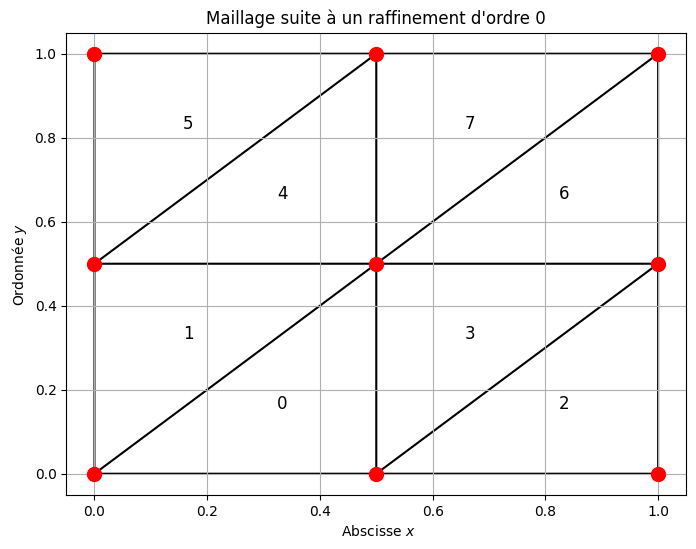

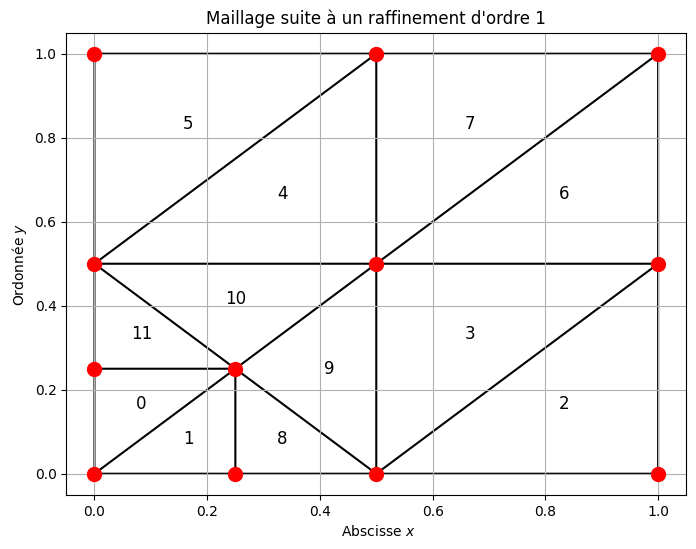

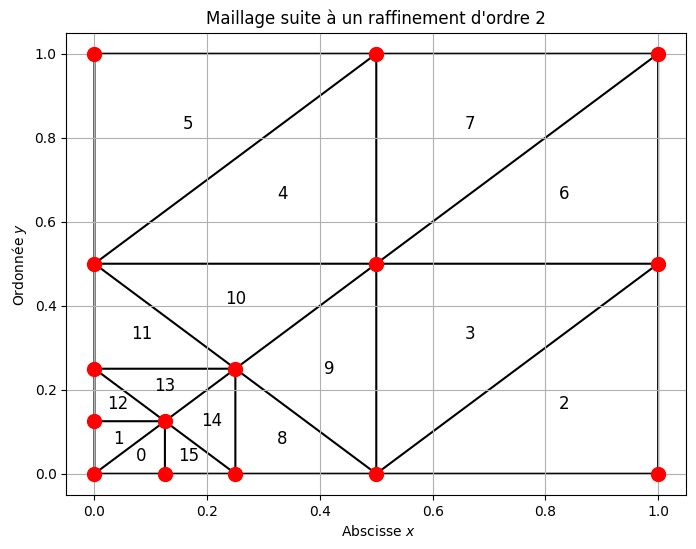

In [4]:
def GenerateRectangleMesh(Lx, Ly, Nx, Ny):

    vtx = []
    elt = []

    # Coordonnées des sommets
    for j in range(Ny + 1):
        for i in range(Nx + 1):
            x = i * (Lx / Nx)
            y = j * (Ly / Ny)
            vtx.append([x, y])

    # Connectivité des éléments
    for j in range(Ny):
        for i in range(Nx):
            n1 = i + j * (Nx + 1)
            n2 = n1 + 1
            n3 = n1 + Nx + 1
            n4 = n3 + 1
            elt.append([n1, n2, n4])
            elt.append([n1, n4, n3])

    return np.array(vtx), np.array(elt)


Lx_1 = 1  # Longueur horizontale
Ly_1 = 1  # Longueur verticale
Nx_1 = 2 # Nombre de sous-divisions horizontales
Ny_1 = 2  # Nombre de sous-divisions verticales

def GeometricRefinement(vtx,elt,r):

    for _ in range(0,r):
        num_nodes = len(vtx)
        triangle_0 = elt[0]
        triangle_1 = elt[1]
        
        s0 = vtx[triangle_0[0]]
        s1 = vtx[triangle_0[1]]
        s2 = vtx[triangle_0[2]]
        s3 = vtx[triangle_1[2]]

        n1 = triangle_0[1]
        n2 = triangle_0[2]
        n3 = triangle_1[2]
        
        mid_pt_x = (s0 + s1) / 2
        mid_pt_xy = (s0 + s2) / 2
        mid_pt_y = (s0 + s3) / 2
        
        MID_PTS = np.array([mid_pt_x,mid_pt_y,mid_pt_xy])
        vtx = np.concatenate((vtx,MID_PTS))
        elt = np.delete(elt, [0, 1], axis=0)
        
        new_elt = np.array([[0, num_nodes + 1, num_nodes + 2], [0, num_nodes + 2, num_nodes]])
        triangle_0 = new_elt[0]
        triangle_1 = new_elt[1]
        t1 = np.array([[n1,num_nodes + 2,num_nodes]])
        t2 = np.array([[n1,num_nodes + 2,n2]])
        t3 = np.array([[n3,num_nodes + 2,n2]])
        t4 = np.array([[num_nodes + 1,num_nodes + 2,n3]])

        elt = np.vstack((new_elt,elt))
        elt = np.concatenate((elt,t1))
        elt = np.concatenate((elt,t2))
        elt = np.concatenate((elt,t3))
        elt = np.concatenate((elt,t4))
    return vtx,elt
vtx_1, elt_1 = GenerateRectangleMesh(Lx_1, Ly_1, Nx_1, Ny_1)
new_vtx_r1,new_elt_r1 = GeometricRefinement(vtx_1,elt_1,1)
new_vtx_r2,new_elt_r2 = GeometricRefinement(vtx_1,elt_1,2)
PlotMesh(vtx_1,elt_1,0)
PlotMesh(new_vtx_r1,new_elt_r1,1)
PlotMesh(new_vtx_r2,new_elt_r2,2)

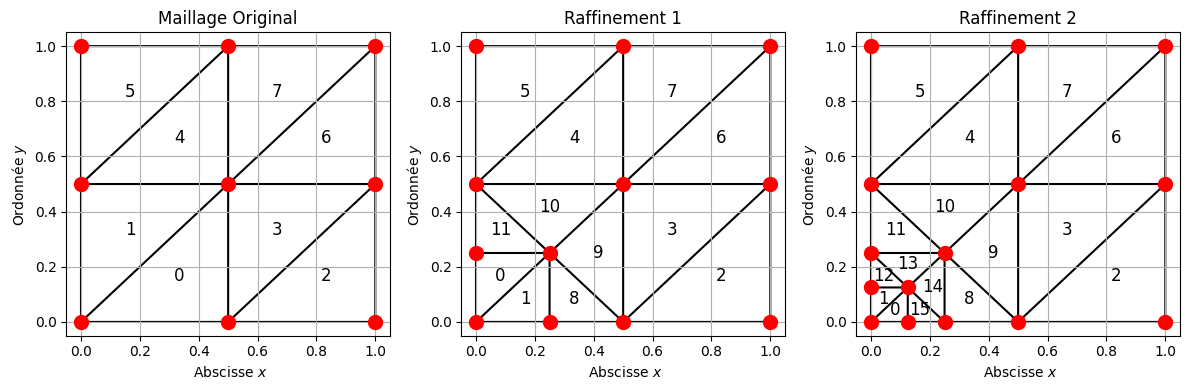

In [5]:
def PlotMultiMesh(vtx,elt,refine,ax=None):
    # Extraire les coordonnées x et y des sommets
    x = vtx[:, 0]
    y = vtx[:, 1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    # Plot du maillage
    ax.triplot(x, y, elt, 'k-') 
    ax.plot(x, y, 'ro', markersize = 10)
    
    # Numéroter les triangles
    for i, triangle in enumerate(elt):
        centroid_x = sum(x[triangle]) / 3
        centroid_y = sum(y[triangle]) / 3
        ax.text(centroid_x, centroid_y, str(i), fontsize=12, ha='center', va='center')
    ax.set_xlabel(r' Abscisse $x$')
    ax.set_ylabel(r'Ordonnée $y$')
    ax.set_title(f"Maillage suite à un raffinement d'ordre {refine}")
    ax.grid(True)
    if not ax:
        plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Maillage original
PlotMultiMesh(vtx_1, elt_1, 0, ax=axs[0])
axs[0].set_title('Maillage Original')

# Plot 2: Raffinement 1
PlotMultiMesh(new_vtx_r1, new_elt_r1, 1, ax=axs[1])
axs[1].set_title('Raffinement 1')

# Plot 3: Raffinement 2
PlotMultiMesh(new_vtx_r2, new_elt_r2, 2, ax=axs[2])
axs[2].set_title('Raffinement 2')

plt.tight_layout()
plt.show()

# Formulation variationnelle :

- Le problème initial est donné par :
$$
\left\{
\begin{array}{ll}
\text{Trouver } u \in H_0^1(\Omega) \text{ tel que :} \\
-\text{div}(\mu \nabla u) + u = f & \text{dans } \Omega \\
u = 0 & \text{sur } \partial \Omega
\end{array}
\right.
$$
- La formulation variationnel est donnée par :
$$
\left\{
\begin{array}{ll}
\text{Trouver } u \in H_0^1(\Omega) \text{ tel que :} \\
a(u,v) = l(v) & \forall v \in H_0^1(\Omega)
\end{array}
\right.
$$

avec :

$$

\begin{array}{ll}
a(u,v) = \int_{\Omega} \mu \nabla u \cdot \nabla \overline{v} \, dx + \int_{\Omega} u\overline{v} \, dx \\
l(v) = \int_{\Omega} f\overline{v} \, dx
\end{array}
$$


# Partie Matrices locales / globales

In [6]:
def Mass_LOC(vtx, e):
    
    # Coordonnées des sommets du triangle
    s1 = vtx[e[0]]
    s2 = vtx[e[1]]
    s3 = vtx[e[2]]

    # Vecteurs représentant deux côtés du triangle
    v1 = s2 - s1
    v2 = s3 - s1

    # Calcul de l'aire du triangle
    aire = np.cross(v1, v2) / 2

    # Matrice de masse élémentaire pour le triangle
    M = 2 * np.diag(np.ones(3)) + np.diag(np.ones(2), 1) + np.diag(np.ones(2), -1)
    M[0][2] = 1
    M[2][0] = 1
    Mloc = (aire / 12) * M

    return Mloc

def Mass(vtx,elt):
    
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)
    d = len(elt[0]) - 1

    rows = np.zeros( ((d+1) ** 2) * nbr_elt, dtype = np.int64)
    cols = np.copy(rows)
    data = np.zeros( ((d+1) ** 2) * nbr_elt, dtype = np.float64)
    
    for Num_elemnt in range(nbr_elt):
        
        element = elt[Num_elemnt]
        M_element = Mass_LOC(vtx, element)
        
        for j in range(d + 1):
            for k in range(d + 1):
                
                i = ( (d+1) ** 2) * (Num_elemnt) + (d + 1) * j + k
               
                rows[i] = elt[Num_elemnt][j] 
                cols[i] = elt[Num_elemnt][k]
                data[i] = M_element[j,k]
    MASS_glob = csr_matrix((data, (rows, cols)), shape = (nbr_vtx,nbr_vtx)).toarray()
    return MASS_glob



def create_mu(x,y,Lx,Ly):
    return 2 + np.sin( (2 * np.pi * x )/Lx) * np.sin( (4 * np.pi * y )/Ly)

def Rigidite_LOC(vtx,e,Lx,Ly):
    d = len(e)
    
    s0 = np.concatenate((np.array(vtx[e[0]]), np.array([0])))
    s1 = np.concatenate((np.array(vtx[e[1]]), np.array([0])))
    s2 = np.concatenate((np.array(vtx[e[2]]), np.array([0])))
    
    s = [s0,s1,s2]

    e3 = np.array([0,0,1])
    
    v0 = -(s1 - s2)
    v1 = -(s2 - s0)
    v2 = -(s0 - s1)
    
    n0 = np.cross(v0,e3)
    n1 = np.cross(v1,e3)
    n2 = np.cross(v2,e3)

    n = [n0,n1,n2]

    aire = np.abs(np.cross(v1,v2))[2] / 2
    Kloc = np.zeros((d,d),dtype = np.float64)
    Interp_mu = (create_mu(s0[0],s0[1],Lx,Ly) + create_mu(s1[0],s1[1],Lx,Ly) + create_mu(s2[0],s2[1],Lx,Ly))

    for j in range(d):
        for k in range(d):
            Kloc[j][k] = np.dot(n[j], n[k]) / (np.dot(s[j] - s[(j + 1) % 3], n[j]) * np.dot(s[k] - s[(k + 1) % 3], n[k]))
    
    return Kloc * aire * Interp_mu * (1/3)

Rigidite_LOC(vtx_1,elt_1[0],Lx_1,Ly_1)


def Rigidite(vtx,elt,Lx,Ly):
    
    d = len(elt[0]) - 1
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)

    rows = np.zeros( ((d+1) ** 2) * nbr_elt, dtype = np.int64)
    cols = np.copy(rows)
    data = np.zeros( ((d+1) ** 2) * nbr_elt, dtype = np.float64)
    
    for Num_elemnt in range(nbr_elt):
        
        element = elt[Num_elemnt]
        K_element = Rigidite_LOC(vtx, element,Lx ,Ly)
        
        for j in range(d + 1):
            for k in range(d + 1):
                
                i = ( (d+1) ** 2) * (Num_elemnt) + (d + 1) * j + k
               
                rows[i] = elt[Num_elemnt][j] 
                cols[i] = elt[Num_elemnt][k]
                data[i] = K_element[j,k]
    Rig_glob = csr_matrix((data, (rows, cols)), shape = (nbr_vtx,nbr_vtx)).toarray()
    return Rig_glob

# Testes

In [7]:
# Test sur la masse pour le maillage initial
 
nbr_vtx1 = len(vtx_1)
print("Aire : ",np.full(nbr_vtx1, fill_value = 1) @ Mass(vtx_1, elt_1)@ np.full(nbr_vtx1, fill_value = 1))
print("L'aire sur chaque triange = ",(0.5 * 0.5) / 2)
print("L'aire du domaine :", 0.125 * 8)

Aire :  1.0
L'aire sur chaque triange =  0.125
L'aire du domaine : 1.0


In [8]:
# Test sur la rigidité pour le maillage initial

Rigidite(vtx_1,elt_1,Lx_1,Ly_1)
nbr_vtx1 = len(vtx_1)
print(r"Test pour U = (1,..,1) : ",np.full(nbr_vtx1, fill_value = 1) @ Rigidite(vtx_1,elt_1,Lx_1,Ly_1)@ np.full(nbr_vtx1, fill_value = 1))
e1 = np.full(nbr_vtx1, fill_value = 1)
e1[0] = 0
e2 = np.full(nbr_vtx1, fill_value = 1)
e2[1] = 0
print("Aire : ",np.abs(e1 @ Rigidite(vtx_1,elt_1,Lx_1,Ly_1)@ e2))


Test pour U = (1,..,1) :  0.0
Aire :  1.0


# Partie Assemblage et Pseudo élimination

In [9]:
def Boundary(elt):
    "TP3"
    boundary_edges = set()
    for triangle_index in range(len(elt)):
        triangle = elt[triangle_index, :] 
        for j in range(3):
            edge = (triangle[j % 3], triangle[(j+1) % 3])
            edge = tuple(np.sort(edge))
            if edge in boundary_edges:
                boundary_edges.remove(edge) 
            else:
                boundary_edges.add(edge)
    return np.array(list(boundary_edges))
"""  --------------------------------------------------------------------------------------- ---"""

def create_boundary_diagonal(elt,boundary):
    
    boundary_edges = boundary(elt)
    boundary_nodes = sorted(set(boundary_edges.flatten()))    
    
    lastElem = list(boundary_nodes).pop()
    exclude = []
    
    for s in range(lastElem):
        if s not in boundary_edges:
            exclude.append(s)
    
    diagonal_matrix = np.eye(lastElem + 1)
    
    for i in exclude:
        diagonal_matrix[i][i] = 0
    
    return diagonal_matrix

"""  --------------------------------------------------------------------------------------- ---"""
def Assemblage(vtx, elt, Lx, Ly):
    M = Mass(vtx, elt)
    K = Rigidite(vtx, elt, Lx, Ly)
    return M + K
"""  --------------------------------------------------------------------------------------- ---"""
def Psuedo_Elimination(vtx, elt, Lx, Ly):
    
    A = Assemblage(vtx, elt, Lx, Ly)
    
    D = create_boundary_diagonal(elt,Boundary)

    I = np.eye(len(vtx))
    
    result = (I - D) @ A + D
    
    return result

# Testes

In [10]:
# Test Boundary :
print("Bord du ddomaine initial : \n",Boundary(elt_1))

# Test create_boundary_diagonal pour créer la Matrice D :
diagonal_matrix = create_boundary_diagonal(elt_1,Boundary)
print("Matrice D cas du maillage initial : \n",diagonal_matrix)

Bord du ddomaine initial : 
 [[0 1]
 [1 2]
 [5 8]
 [0 3]
 [6 7]
 [3 6]
 [2 5]
 [7 8]]
Matrice D cas du maillage initial : 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Partie solution exacte et calcul des dérivées partielles 

In [11]:
def Exact_solution(x,y,Lx,Ly,alpha):
    return ((x * y) ** alpha) * (x - Lx) * (y - Ly) 

def Du_x(x,y,Lx,Ly,alpha):
    if(alpha <= 0.5): # pour débugger
        print("Erreur dans la valeur de alpha")
        du_x = -np.inf
    elif(alpha == 1):
        du_x = (y - Ly) * (y * (x - Lx) + x*y)
    else:
        if(x == 0 or y == 0):
            du_x = 0
        else:
            du_x = ((y ** alpha ) * (y - Ly)) * (alpha * (x ** (alpha - 1)) * (x - Lx) + x ** alpha )
    return du_x

def Du_y(x,y,Lx,Ly,alpha):
    if(alpha <= 0.5):
        print("Erreur dans la valeur de alpha")
        du_y = -np.inf
    elif(alpha == 1):
        du_y = (x - Lx) * (x * (y - Ly) + x*y)
    else:
        if(x == 0 or y == 0):
            du_y = 0
        else:
            du_y = ((x ** alpha ) * (x - Lx)) * (alpha * (y ** (alpha - 1)) * (y - Ly) + y ** alpha )
    return du_y

def Partial_derivative_U(x,y,Lx,Ly,alpha):
    
    
    result_Du_x = Du_x(x, y,Lx, Ly, alpha)
    result_Du_y = Du_y(x, y,Lx, Ly, alpha)
    
    return (result_Du_x,result_Du_y)

def Du2_x(x,y,Lx,Ly,alpha):
    if(alpha <= 0.5):
        print("Erreur dans la valeur de alpha")
        du2_x = -np.inf
    elif(alpha == 1):
        du2_x = 2 * y * (y - Ly)
    else:
        if(x == 0 or y == 0):
            du2_x = 0
        else:
            du2_x = ( (y ** alpha) * (y - Ly) ) * (alpha * (alpha - 1) * x ** (alpha - 2) * (x - Lx) + 2 * alpha * x ** (alpha - 1))
    return du2_x

def Du2_y(x,y,Lx,Ly,alpha):
    if(alpha <= 0.5):
        print("Erreur dans la valeur de alpha")
        du2_y = -np.inf
    elif(alpha == 1):
        du2_y = 2 * x * (x - Lx)
    else:
        if(x == 0 or y == 0):
            du2_y = 0
        else:
            du2_y = ( (x ** alpha) * (x - Lx) ) * (alpha * (alpha - 1) * y ** (alpha - 2) * (y - Ly) + 2 * alpha * y ** (alpha - 1))
    return du2_y

def Second_Partial_derivative_U(x,y,Lx,Ly,alpha):

    result_Du2_x = Du2_x(x, y, Lx, Ly, alpha)
    result_Du2_y = Du2_y(x, y, Lx, Ly, alpha)
    
    return (result_Du2_x,result_Du2_y)


def dmu_x(x,y,Lx,Ly):
    return (2 * np.pi / Lx) * np.cos((2 * np.pi * x) / Lx) * np.sin((4 * np.pi * y) / Ly)

def dmu_y(x,y,Lx,Ly):
    return (4 * np.pi / Ly) * np.sin((2 * np.pi * x) / Lx) * np.cos((4 * np.pi * y) / Ly)

def Partial_derivative_mu(x,y,Lx,Ly):    
    
    result_x = dmu_x(x,y,Lx,Ly)
    result_y = dmu_y(x,y,Lx,Ly)
    
    return (result_x,result_y)

# Testes

In [12]:
# Test des foncitons pour des valeurs arbitraires :
print(Partial_derivative_U(2,2,1,1,2)[1])
print(Second_Partial_derivative_U(2,2,1,1,1)[1])
print(Partial_derivative_mu(np.pi * Lx_1 / 2 , 0,Lx_1,Ly_1)[0])
print(Partial_derivative_mu(0 , 4*np.pi / Ly_1,Lx_1,Ly_1)[1])

32
4
-0.0
0.0


# Partie second membre

In [13]:
def exact_f(x,y,Lx,Ly,alpha):
    
    #création des données : 

    mu = create_mu(x,y,Lx,Ly)
    Grad_mu = Partial_derivative_mu(x,y,Lx,Ly)
    Laplacian_u = Second_Partial_derivative_U(x,y,Lx,Ly,alpha)[0] + Second_Partial_derivative_U(x,y,Lx,Ly,alpha)[1]
    Grad_u = Partial_derivative_U(x,y,Lx,Ly,alpha)
    u = Exact_solution(x,y,Lx,Ly,alpha)

    result = - mu * Laplacian_u - np.dot(Grad_mu,Grad_u) + u
    return result

def create_vertex_triangle_dict(elt):

    vertex_triangle_dict = {}
    
    for i, triangle in enumerate(elt):

        for vertex_index in triangle:
    
            if vertex_index not in vertex_triangle_dict:
    
                vertex_triangle_dict[vertex_index] = []
    
            vertex_triangle_dict[vertex_index].append(i)
    return vertex_triangle_dict

def Approx_f(vtx, elt, Lx, Ly, alpha):
    
    
    nbr_vtx = len(vtx)
    
    F = np.zeros(nbr_vtx)
    
    vertex_triangle_dict = create_vertex_triangle_dict(elt)
    
    for k in range(nbr_vtx):
        
        if k in vertex_triangle_dict:
        
            triangles_with_vertex_k = vertex_triangle_dict[k]
        
            for triangle_index in triangles_with_vertex_k:
        
                triangle = elt[triangle_index]
                s0, s1, s2 = vtx[triangle]
                Barycentre = (s0 + s1 + s2) / 3
                aire = np.linalg.norm(np.cross(vtx[elt[0]]-vtx[elt[1]],vtx[elt[1]]-vtx[elt[2]]))/2
                F[k] += exact_f(Barycentre[0], Barycentre[1],Lx, Ly, alpha) * 1/3 * aire
    
    return F

# Résolution du système linéaire

In [25]:
def Linear_system(Lx,Ly,Nx,Ny,alpha):
    
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    membre_gauche = Psuedo_Elimination(vtx,elt,Lx,Ly)
    D = create_boundary_diagonal(elt,Boundary)
    I = np.eye(len(vtx))
    f = Approx_f(vtx, elt ,Lx ,Ly ,alpha)
    membre_droit = (I - D) @ f

    Solution = np.linalg.solve(membre_gauche,membre_droit)
    return Solution
print(Linear_system(1,1,2,2,1))

[ 0.00000000e+00 -3.33066907e-17  0.00000000e+00  0.00000000e+00
  7.00511346e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


# Partie de la représentation graphique 

In [15]:
def PlotApproximation(vtx, elt, field_values,string):
    triang = Triangulation(vtx[:, 0], vtx[:, 1], triangles = elt)
    fig, ax = plt.subplots()
    figure = ax.tripcolor(triang,field_values)
    fig.colorbar(figure)
    plt.plot(vtx[:, 0], vtx[:, 1], 'o', color='black',markersize=1)
    plt.xlabel('Abscisse x')
    plt.ylabel('Ordonnée y')
    plt.title(f'{string}')
    plt.axis('equal')
    plt.show()

In [16]:
def Interpolate_U_exact(vtx, alpha,Lx,Ly):
    
    nbr_vtx = len(vtx)
    interpolated_values = np.zeros(nbr_vtx)
    
    for i, node in enumerate(vtx):
        x, y = node
        interpolated_values[i] = Exact_solution(x, y, Lx, Ly, alpha)

    return interpolated_values

def Error(vtx,Lx,Ly,Nx,Ny,alpha):

    uh = Linear_system(Lx,Ly,Nx,Ny,alpha)
    Πu = Interpolate_U_exact(vtx, alpha, Lx, Ly)

    return np.abs(uh - Πu)


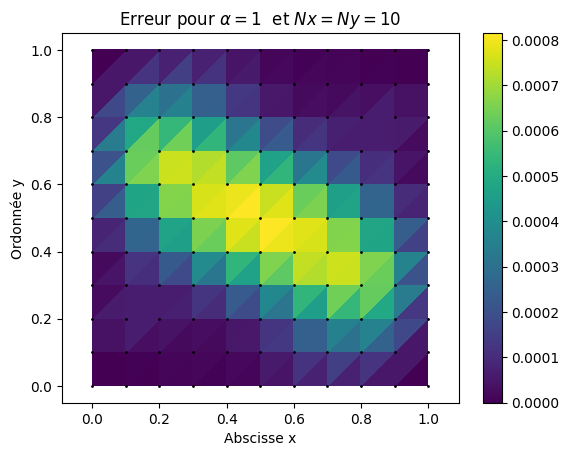

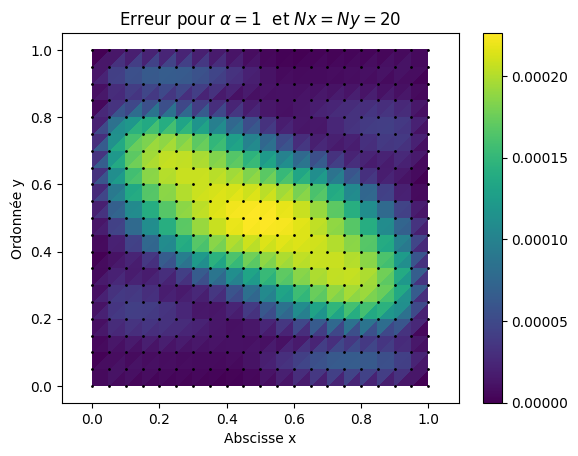

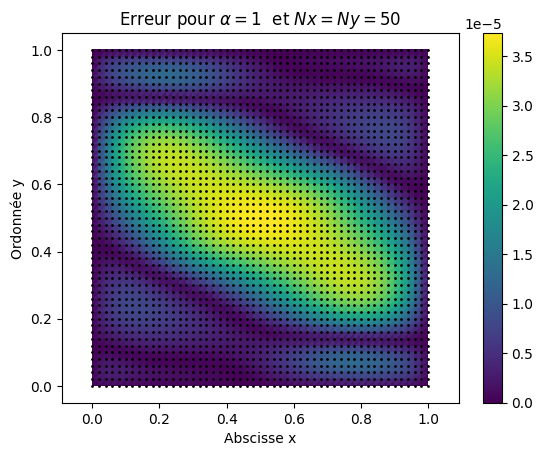

In [17]:
Lx = 1
Ly = 1

N10 = 10
N20 = 20
N50 = 50

alpha = 1

vtx10,elt10 = GenerateRectangleMesh(Lx,Ly,N10,N10)
vtx20,elt20 = GenerateRectangleMesh(Lx,Ly,N20,N20)
vtx50,elt50 = GenerateRectangleMesh(Lx,Ly,N50,N50)


e10 = Error(vtx10,Lx,Ly,N10,N10,alpha) 
e20 = Error(vtx20,Lx,Ly,N20,N20,alpha) 
e50 = Error(vtx50,Lx,Ly,N50,N50,alpha) 

PlotApproximation(vtx10,elt10,e10,r"Erreur pour $\alpha = 1$  et $Nx = Ny = 10$")
PlotApproximation(vtx20,elt20,e20,r"Erreur pour $\alpha = 1$  et $Nx = Ny = 20$")
PlotApproximation(vtx50,elt50,e50,r"Erreur pour $\alpha = 1$  et $Nx = Ny = 50$")

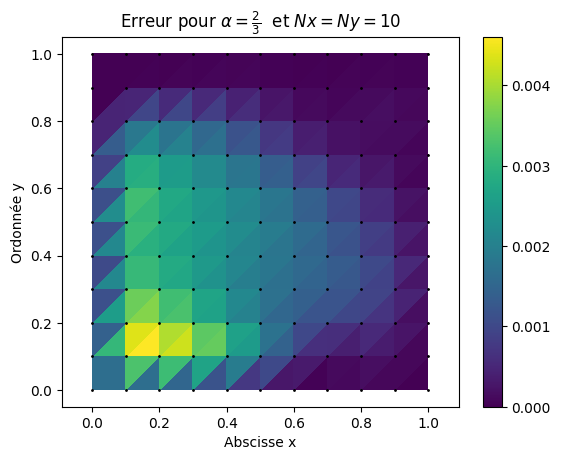

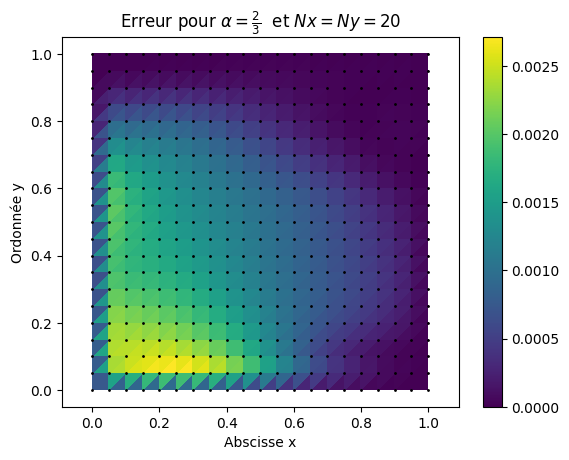

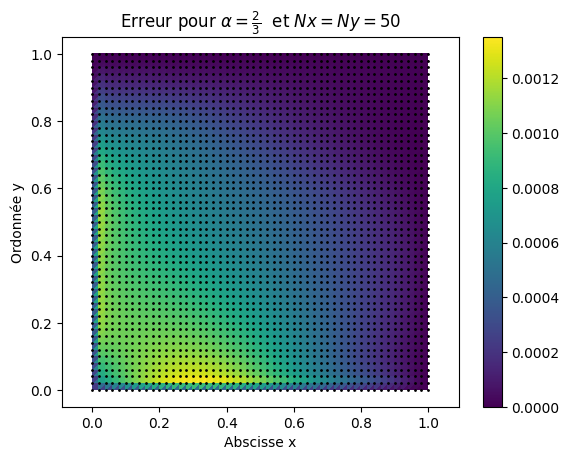

In [18]:
alpha = 2/3

e_10 = Error(vtx10,Lx,Ly,N10,N10,alpha) 
e_20 = Error(vtx20,Lx,Ly,N20,N20,alpha) 
e_50 = Error(vtx50,Lx,Ly,N50,N50,alpha) 

PlotApproximation(vtx10,elt10,e_10,r"Erreur pour $\alpha = \frac{2}{3}$  et $Nx = Ny = 10$")
PlotApproximation(vtx20,elt20,e_20,r"Erreur pour $\alpha = \frac{2}{3}$  et $Nx = Ny = 20$")
PlotApproximation(vtx50,elt50,e_50,r"Erreur pour $\alpha = \frac{2}{3}$  et $Nx = Ny = 50$")


# Partie étude de la convergence :

**Analyse de la convergence : La norme $ \| \cdot \|_{L^2}$ avec  $\alpha = 1$**

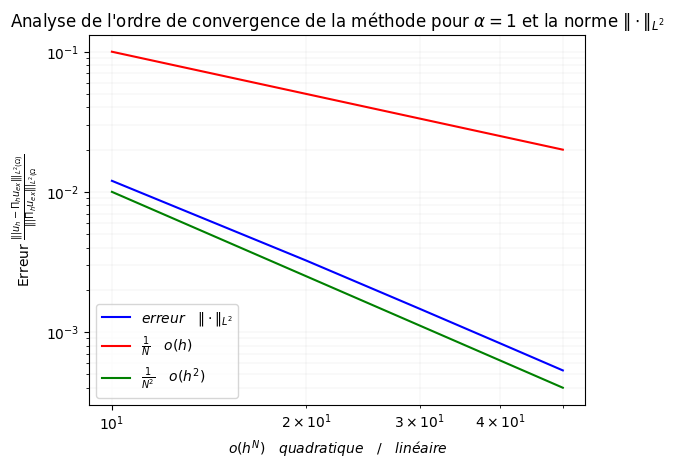

In [19]:
def convergence_L2(Lx, Ly, Nx, Ny, alpha):
    vtx, _ = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    Uh = Linear_system(Lx, Ly, Nx, Ny, alpha)
    Πu = Interpolate_U_exact(vtx, alpha, Lx, Ly)
    Ratios = np.linalg.norm(Uh - Πu) / np.linalg.norm(Πu)
    return Ratios

norm_ratios = []
N_values = []
quad_conv_order = []
lin_conv_order = []


values = []
Linear_cvg = []
Error_N = []
Quadratic_cvg = []

Lx = 1
Ly = 1
alpha = 1

N_list_values = [10, 20, 30, 40, 50]
for N in N_list_values:

    res = convergence_L2(Lx, Ly, N, N, alpha)
    norm_ratios.append(res)
    lin_conv_order.append(1/N)
    quad_conv_order.append(1/N**2)
    N_values.append(N)

plt.loglog(N_values, norm_ratios,color='blue',label=r'$erreur \quad \| \cdot \|_{L^2} $')
plt.plot(N_values, lin_conv_order,color='red', label=r"$\frac{1}{N} \quad o(h)$")
plt.plot(N_values, quad_conv_order,color='green', label=r"$\frac{1}{N^2}\quad o(h^2)$")
plt.title(r"Analyse de l'ordre de convergence de la méthode pour $\alpha = 1$ et la norme $ \| \cdot \|_{L^2}$")
plt.xlabel(r"$ o(h^N) \quad quadratique \quad / \quad linéaire $")
plt.ylabel(r'Erreur $\frac{\||u_h - \Pi_h u_{ex}\||_{L^2(\Omega)}}{\||\Pi_h u_{ex}\||_{L^2(\Omega}}$')
plt.grid(True, which='both', linestyle = '-', linewidth = 0.1)
plt.legend()
plt.show()


**Analyse de la convergence : La norme $ \| \cdot \|_{L^2}$ avec  $\alpha = \frac{2}{3}$**

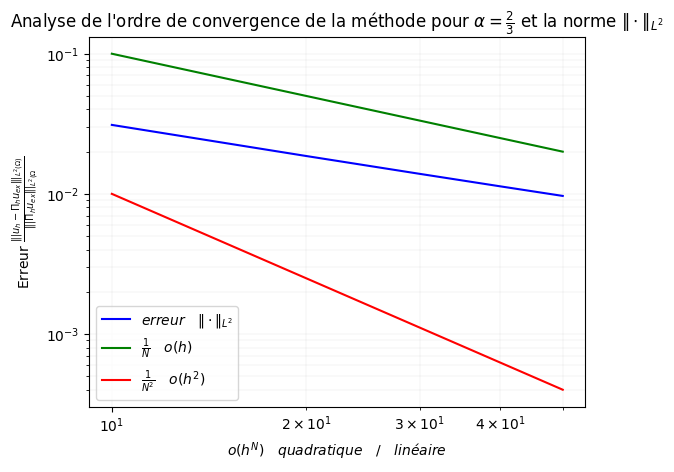

In [20]:
norm_ratios = []
N_values = []
quad_conv_order = []
lin_conv_order = []
puis_unTiere = []
Lx = 1
Ly = 1
alpha = 2/3

N_list_values = [10, 20, 30, 40, 50]
for N in N_list_values:

    res = convergence_L2(Lx, Ly, N, N, alpha)
    norm_ratios.append(res)
    lin_conv_order.append(1/N)
    quad_conv_order.append(1/N**2)
    puis_unTiere.append(1/N**1/3)
    N_values.append(N)

plt.loglog(N_values, norm_ratios,color='blue', label=r'$erreur \quad \| \cdot \|_{L^2} $')
plt.plot(N_values, lin_conv_order,color='green' ,label=r"$\frac{1}{N} \quad o(h)$")
plt.plot(N_values, quad_conv_order,color='red' ,label=r"$\frac{1}{N^2}\quad o(h^2)$")
plt.title(r"Analyse de l'ordre de convergence de la méthode pour $\alpha = \frac{2}{3}$ et la norme $ \| \cdot \|_{L^2}$")
plt.xlabel(r"$ o(h^N) \quad quadratique \quad / \quad linéaire $")
plt.ylabel(r'Erreur $\frac{\||u_h - \Pi_h u_{ex}\||_{L^2(\Omega)}}{\||\Pi_h u_{ex}\||_{L^2(\Omega}}$')
plt.grid(True, which='both', linestyle = '-', linewidth = 0.1)
plt.legend()
plt.show()

**Analyse de la convergence : La norme $ \| \cdot \|_{H^1}$ avec  $\alpha = 1$**

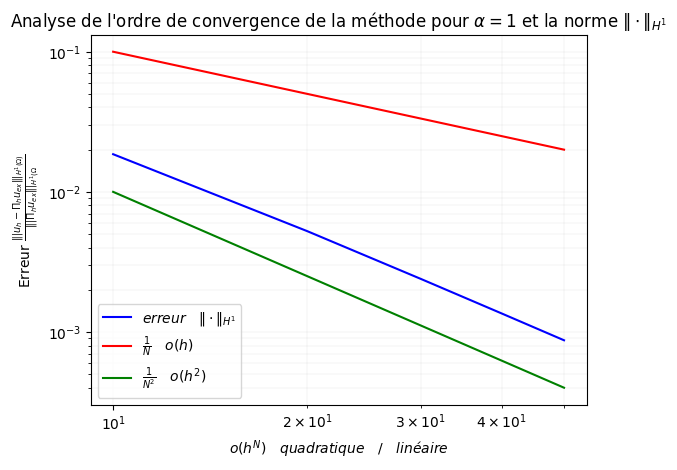

In [21]:
def convergence_H1(Nx,Ny,alpha,Lx = 1,Ly = 1):
    vtx,elt = GenerateRectangleMesh(Lx, Ly, Nx, Ny)
    #vtx,elt = GeometricRefinement(vtx,elt,0)
    M =  Mass(vtx,elt)
    K = Rigidite(vtx,elt,Lx,Ly)
    Uh = Linear_system(Lx,Ly,Nx,Ny,alpha)
    Πu = Interpolate_U_exact(vtx,alpha,Lx,Ly)
    U_star = Uh - Πu
    result = (U_star @ M @ U_star + U_star @ K @ U_star) / (Πu @ M @ Πu + Πu @ K @ Πu)
    return np.sqrt(result)

norm_ratios = []
N_values = []
quad_conv_order = []
lin_conv_order = []

N_list_values = [10, 20, 30, 40, 50]
for N in N_list_values:

    res = convergence_H1(N,N,1)
    norm_ratios.append(res)
    N_values.append(N)
    quad_conv_order.append(1/N**2)
    lin_conv_order.append(1/N)

plt.loglog(N_values, norm_ratios,color='blue', label=r'$erreur \quad \| \cdot \|_{H^1} $')
plt.plot(N_values, lin_conv_order,color='red' ,label=r"$\frac{1}{N} \quad o(h)$")
plt.plot(N_values, quad_conv_order,color='green' ,label=r"$\frac{1}{N^2}\quad o(h^2)$")
plt.title(r"Analyse de l'ordre de convergence de la méthode pour $\alpha = 1$ et la norme $ \| \cdot \|_{H^1}$")
plt.xlabel(r"$ o(h^N) \quad quadratique \quad / \quad linéaire $")
plt.ylabel(r'Erreur $\frac{\||u_h - \Pi_h u_{ex}\||_{H^1(\Omega)}}{\||\Pi_h u_{ex}\||_{H^1(\Omega}}$')
plt.grid(True, which='both', linestyle = '-', linewidth = 0.1)
plt.legend()
plt.show()

**Analyse de la convergence : La norme $ \| \cdot \|_{H^1}$ avec  $\alpha = 2/3$**

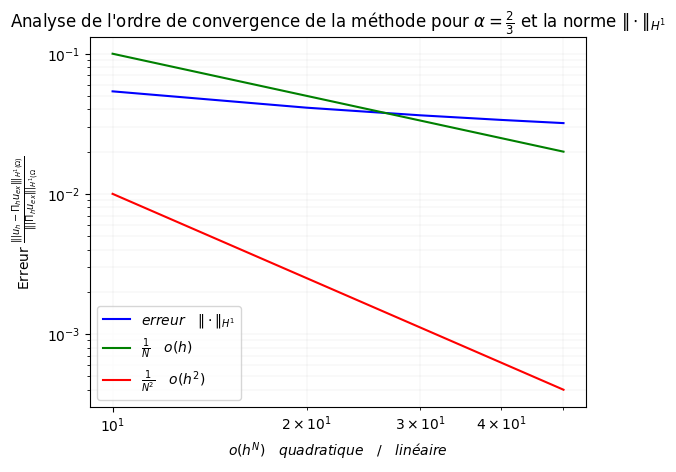

In [22]:
norm_ratios = []
N_values = []
quad_conv_order = []
lin_conv_order = []

N_list_values = [10, 20, 30, 40, 50]
for N in N_list_values:

    res = convergence_H1(N,N,2/3)
    norm_ratios.append(res)
    N_values.append(N)
    quad_conv_order.append(1/N**2)
    lin_conv_order.append(1/N)

plt.loglog(N_values, norm_ratios,color='blue', label=r'$erreur \quad \| \cdot \|_{H^1} $')
plt.plot(N_values, lin_conv_order,color='green' ,label=r"$\frac{1}{N} \quad o(h)$")
plt.plot(N_values, quad_conv_order,color='red' ,label=r"$\frac{1}{N^2}\quad o(h^2)$")
plt.title(r"Analyse de l'ordre de convergence de la méthode pour $\alpha = \frac{2}{3}$ et la norme $ \| \cdot \|_{H^1}$")
plt.xlabel(r"$ o(h^N) \quad quadratique \quad / \quad linéaire $")
plt.ylabel(r'Erreur $\frac{\||u_h - \Pi_h u_{ex}\||_{H^1(\Omega)}}{\||\Pi_h u_{ex}\||_{H^1(\Omega}}$')
plt.grid(True, which='both', linestyle = '-', linewidth = 0.1)
plt.legend()
plt.show()